# Step1 Retrieve GO

In [1]:
import os
import pandas as pd

In [ ]:
def retrieve(go_save_dir, task, df):
        for id in df['uniprot_id']:
            os.system(f"grep -w {id} datasets/idmapping_select.tab > {go_save_dir}/{task}/{id}.txt")

def integrate(go_save_dir, task, df):
    goterms = []
    for id in df['uniprot_id']:
        f = open(f"{go_save_dir}/{task}/{id}.txt", "r")
        content = f.read()
        f.close()
        go = content.strip().split("\t")[6]
        goterms.append(go if go != "" else "No goterm")
    df['GO'] = goterms
    
    if task in ['stability', 'fluorescence', 'remote_homology', 'secondary_structure']:
        df = df[['uniprot_id', 'seq', 'GO', 'label']]
    elif task == 'pdbbind':
        df = df[['uniprot_id', 'seq', 'smiles', 'rdkit_smile', 'GO', 'label', 'dataset_type']]
    else:
        df = df[['molecule','uniprot_id','seq','GO','label']]
    
    return df

def process_go(dataset_dir, data_pth):
    go_save_dir = os.path.join(dataset_dir, 'go')
    data_file = data_pth.split("/")[-1]
    task, dataset_type = data_file.split(".")[0], data_file.split(".")[1]
    if not os.isdir(os.path.join(go_save_dir, task)):
        os.makedirs(os.path.join(go_save_dir, task))
        
    abbrs = {'stability': 'stab', 'remote_homology': 'remo', 'fluorescence': 'fluo', 'secondary_structure': 'secstruc'}
    df = pd.read_csv(data_pth)
    if task in ['stability', 'remote_homology', 'fluorescence', 'secondary_structure']:
        df.insert(0, 'uniprot_id', [f"{abbrs[task]}_{dataset_type}_{i}" for i in range(0, len(df))])
 
    retrieve(go_save_dir, task, df)
    new_df = integrate(go_save_dir, task, df)
    
    if not os.isdir(dataset_dir, f"new/{task}"):
        os.makedirs(os.path.join(dataset_dir, f"new/{task}"))
    
    new_df.to_csv(os.path.join(dataset_dir, f"new/{task}/{data_file}"), index=False)


In [ ]:
texts_embs_hub = {
    'st': ["datasets/raw/stability/stability.train.txt",
            "datasets/raw/stability/stability.valid.txt",
            "datasets/raw/stability/stability.test.txt"],
    'fl': ["datasets/raw/fluorescence/fluorescence.train.txt",
            "datasets/raw/fluorescence/fluorescence.valid.txt",
            "datasets/raw/fluorescence/fluorescence.test.txt"],
    'rh': ["datasets/raw/remote_homology/remote_homology.train.txt",
            "datasets/raw/remote_homology/remote_homology.valid.txt",
            "datasets/raw/remote_homology/remote_homology.test.txt"],
    'ss': ["datasets/raw/secondary_structure/secondary_structure.train.txt",
            "datasets/raw/secondary_structure/secondary_structure.valid.txt",
            "datasets/raw/secondary_structure/secondary_structure.test.txt"],
    'pb': ["datasets/raw/pdbbind/pdbbind.train.txt",
           "datasets/raw/pdbbind/pdbbind.valid.txt",
           "datasets/raw/pdbbind/pdbbind.test.txt"],
    'ki': ["datasets/raw/kinase/kinase.train.txt",
           "datasets/raw/kinase/kinase.test.txt"], # no vaild
}

for task in ['st', 'fl', 'rh', 'pb']:
    for data_pth in texts_embs_hub[task]:
        process_go('datasets/', data_pth)

# Step2 Processing label

<Figure size 640x480 with 0 Axes>

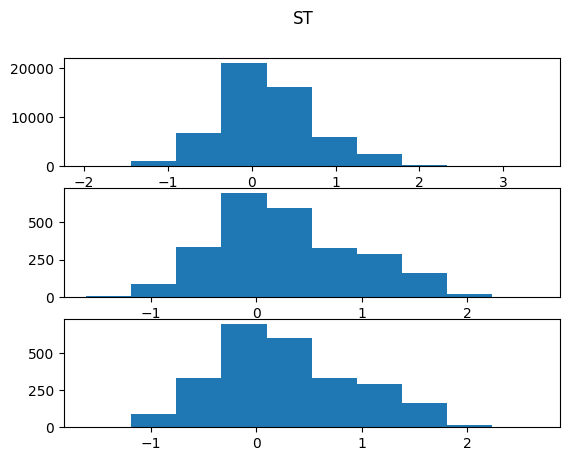

<Figure size 640x480 with 0 Axes>

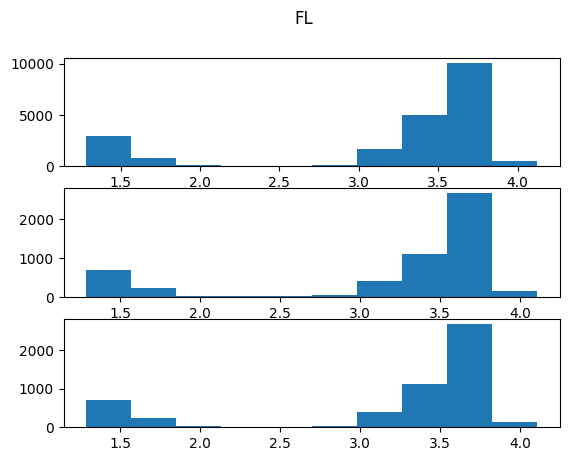

<Figure size 640x480 with 0 Axes>

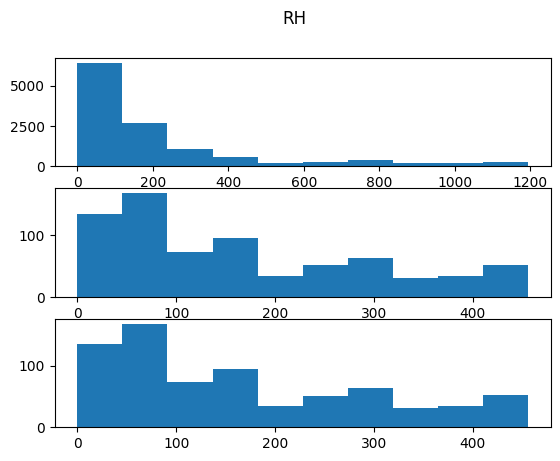

<Figure size 640x480 with 0 Axes>

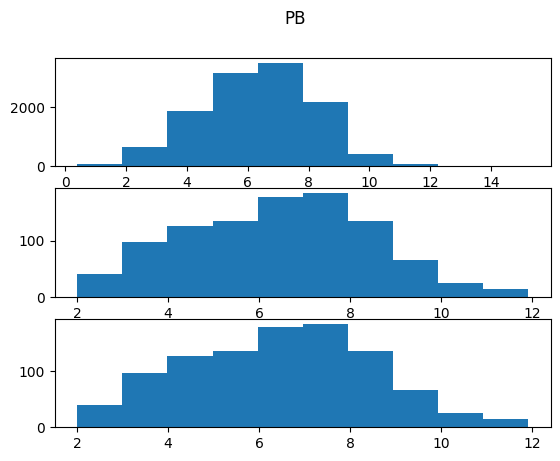

In [16]:
import os
import time
import collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

texts_embs_hub = {
    'st': ["datasets/new/stability/stability.train.txt",
            "datasets/new/stability/stability.valid.txt",
            "datasets/new/stability/stability.test.txt"],
    'fl': ["datasets/new/fluorescence/fluorescence.train.txt",
            "datasets/new/fluorescence/fluorescence.valid.txt",
            "datasets/new/fluorescence/fluorescence.test.txt"],
    'rh': ["datasets/new/remote_homology/remote_homology.train.txt",
            "datasets/new/remote_homology/remote_homology.valid.txt",
            "datasets/new/remote_homology/remote_homology.test.txt"],
    'ss': ["datasets/new/secondary_structure/secondary_structure.train.txt",
            "datasets/new/secondary_structure/secondary_structure.valid.txt",
            "datasets/new/secondary_structure/secondary_structure.test.txt"],
    'pb': ["datasets/new/pdbbind/pdbbind.train.txt",
           "datasets/new/pdbbind/pdbbind.valid.txt",
           "datasets/new/pdbbind/pdbbind.test.txt"],
    'ki': ["datasets/new/kinase/kinase.train.txt",
           "datasets/new/kinase/kinase.test.txt"], # no vaild
}


def get_texts(train_pth, valid_pth, test_pth=None, cat=False):
    train_texts, valid_texts = pd.read_csv(train_pth), pd.read_csv(valid_pth)
    if test_pth is not None:
        test_texts = pd.read_csv(test_pth)
    if cat:
        if test_pth is None:
            cat_texts = pd.concat([train_texts, valid_texts], axis=0)
        else:
            cat_texts = pd.concat([train_texts, valid_texts, test_texts], axis=0)
        return cat_texts 
    else:
        return train_texts, valid_texts, test_texts

# 分析train, valid数据分布
for task in ['st', 'fl', 'rh', 'pb']:
    trn_texts, val_texts, tst_texts = get_texts(*texts_embs_hub[task], cat=False)
    plt.figure()
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
    ax1.hist(trn_texts['label'])
    ax2.hist(val_texts['label'])
    ax3.hist(val_texts['label'])
    plt.suptitle(task.upper())
#     plt.savefig("./results/{}_distrib.jpg".format(task))

### 1.Processing ST(Stability), FL(Fluorescence), RH(Remote Homology), PB(Pdbbind) label
50 bins approximately, random sample, reindex continous label

In [18]:

st_texts = get_texts(*texts_embs_hub['st'], cat=True)
fl_texts = get_texts(*texts_embs_hub['fl'], cat=True)
rh_texts = get_texts(*texts_embs_hub['rh'], cat=True) 
pb_texts = get_texts(*texts_embs_hub['pb'], cat=True)

def lbls_to_idxs_sorted(texts):
    counter = collections.Counter(texts['label'])
    sorted_counter = dict(sorted(counter.items(), key=lambda kv: kv[1], reverse=True))
    lbl_to_idx = {lbl: idx for idx, lbl in enumerate(sorted_counter.keys())}
    texts['label'] = texts['label'].map(lambda x: lbl_to_idx[x])
    return texts, sorted_counter

def label_processor(task, texts, bins=50, seed=1145114):
    bin_labels = pd.cut(texts['label'], bins=bins, labels=False, ordered=True)
    texts['label'] = bin_labels 
    texts, sorted_counter = lbls_to_idxs_sorted(texts)
    print("{} unique labels: {}".format(task.capitalize(), len(sorted_counter)),
            "\n", sorted_counter)
    return texts

bins, seed = 20, 1145114
num_samples = 'all'
for task, texts in list(zip(['stability', 'fluorescence', 'remote_homology', 'pdbbind'], [st_texts, fl_texts, rh_texts, pb_texts])):
    if num_samples != 'all':
        texts = texts.sample(n=num_samples, random_state=seed)
        texts.reset_index(drop=True, inplace=True)
    
    texts = label_processor(task, texts, bins, seed)
    
    texts = texts[['uniprot_id', 'seq', 'GO', 'label']]
    print(texts['label'].value_counts())
    
    os.makedirs("./processed_data/{}".format(task), exist_ok=True)
    texts.to_csv("./processed_data/{}/sequence_go_label_{}.txt".format(task, num_samples), index=False)

Stability unique labels: 20 
 {7: 12328, 8: 11278, 6: 9892, 9: 8062, 10: 6978, 11: 5951, 5: 5036, 12: 3472, 13: 2348, 4: 2091, 3: 799, 14: 316, 2: 269, 1: 81, 15: 32, 0: 16, 16: 13, 17: 10, 19: 3, 18: 2}
Fluorescence unique labels: 20 
 {0: 13800, 16: 10410, 15: 6165, 17: 5819, 1: 4432, 2: 3503, 14: 3218, 13: 3143, 3: 999, 18: 718, 12: 621, 4: 380, 11: 303, 9: 107, 6: 99, 10: 92, 19: 79, 5: 73, 7: 32, 8: 32}
Remote_homology unique labels: 20 
 {0: 3932, 1: 3184, 2: 2491, 4: 736, 5: 536, 3: 532, 7: 458, 6: 336, 13: 226, 19: 157, 10: 151, 12: 142, 17: 137, 14: 133, 8: 122, 18: 120, 15: 101, 11: 99, 9: 92, 16: 81}
Pdbbind unique labels: 20 
 {9: 1955, 8: 1864, 7: 1854, 10: 1586, 6: 1548, 5: 1240, 4: 850, 11: 818, 3: 542, 12: 381, 2: 219, 13: 124, 14: 74, 1: 68, 15: 34, 0: 16, 17: 8, 16: 8, 18: 4, 19: 3}


### 2.Processing SS(Secondary Structure) label
random sample, mds reduction, kmeans cluster as label

In [ ]:
from sklearn.manifold import MDS
from sklearn.cluster import KMeans

ss_texts = get_texts(*texts_embs_hub['ss'], cat=True)
num_samples = 2500

if num_samples != 'all':
    ss_texts = ss_texts.sample(n=num_samples, random_state=seed)
    ss_texts.reset_index(drop=True, inplace=True)
    
ss_texts['label_len'] = ss_texts['label'].map(lambda x: len(x))

ss_max_lbl_len = ss_texts['label_len'].max()
# pad (-1): seq_len -> max_seq_len
ss_pad_idx_labels = ss_texts['label'].map(lambda x: [int(n) for n in x]+[-1]*(ss_max_lbl_len-len(x)))
ss_pad_idx_labels_arr = np.stack(ss_pad_idx_labels, axis=0)

# MDS Reduction
print("MDS reducing dimensions...")
ts = time.time()
embedding = MDS(n_components=2, n_init=4, max_iter=300, n_jobs=-1)
mds_embs = embedding.fit_transform(ss_pad_idx_labels_arr)
print("Finish MDS in {:.2f} secs".format(time.time()-ts))
# KMEANS cluster label as final label
print("KMEANS clustering...")
ts = time.time()
kmeans = KMeans(n_clusters=20, n_init=10, max_iter=1000, random_state=1145114).fit(mds_embs)
print("Finish KMEANS in {} secs".format(time.time()-ts))
ss_cluster_label = kmeans.labels_

# 保存
labelized_ss_texts = ss_texts[['uniprot_id', 'seq', 'GO', 'label']]
labelized_ss_texts['label'] = ss_cluster_label
os.makedirs("./processed_data/secondary_structure", exist_ok=True)
labelized_ss_texts.to_csv(f"./processed_data/secondary_structure/sequence_go_label_{num_samples}.txt", index=False,
                        header=['uniprot_id', 'seq', 'GO', 'label'])
print(labelized_ss_texts[3].value_counts())

### 3.Processing KI(Kinase) label

In [ ]:
ki_texts = pd.concat([pd.read_csv(texts_embs_hub['ki'][0]),
                      pd.read_csv(texts_embs_hub['ki'][1])], axis=0).reset_index(drop=True)

renamed_ids_train = pd.read_csv("datasets/new/kinase/kinase.train.txt")
renamed_ids_test = pd.read_csv("datasets/new/kinase/kinase.test.txt")
renamed_ids = pd.concat([renamed_ids_train, renamed_ids_test], axis=0).reset_index(drop=True)

num_samples = 2500
if num_samples != 'all':
    ki_texts = ki_texts.sample(n=num_samples, random_state=seed)
    ki_texts.reset_index(drop=True, inplace=True)
    
# 0.0, 1.0 -> 0, 1
ki_texts['label'] = ki_texts['label'].astype(int)

ki_texts = ki_texts[['uniprot_id', 'seq', 'GO', 'label']]
os.makedirs("./processed_data/kinase", exist_ok=True)
ki_texts.to_csv(f"./processed_data/kinase/sequence_go_label_{num_samples}.txt", index=False,
                header=['uniprot_id', 'seq', 'GO', 'label'])
print(ki_texts['label'].value_counts())